In [1]:
!pip install brian2

  Created wheel for brian2: filename=Brian2-2.4.2-cp37-cp37m-win_amd64.whl size=858683 sha256=c776a55392b0430299735ac70d04bba9e6ede40ac3f1db75231e972505f0396f
  Stored in directory: c:\users\amirhossein\appdata\local\pip\cache\wheels\ec\f8\22\34f71a38e2efba1a88d548d18cd2a8fe35692879503e97b5f7
  Created wheel for py-cpuinfo: filename=py_cpuinfo-8.0.0-py3-none-any.whl size=22250 sha256=4b8c76b361d2f3f92173512896ee97e0751f588705ff99e9dcbe7911c4ff8cd7
  Stored in directory: c:\users\amirhossein\appdata\local\pip\cache\wheels\d2\f1\1f\041add21dc9c4220157f1bd2bd6afe1f1a49524c3396b94401
Successfully built brian2 py-cpuinfo


You should consider upgrading via the 'c:\users\amirhossein\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


In [17]:
import numpy as np
from brian2 import *
from random import randrange
import math

In [18]:
def make_poisson_pattern_current(N , patterns , duration , delta_time , possibility):
    l = 0
    for i in patterns:
        if max(i) > l:
            l = max(i)
            
    which_neuron = []
    spike_time = []
    pattern_time = []
    which_pattern = []
    
    pre = 0

    for i in range (int((duration/ms - 400) /(delta_time/ms *l))):
        base = i*l
        choice = np.random.choice([1,0],p=[possibility , 1-possibility])
        
#         if pre == 1:
#             choice = 0
#             pre = 0
            
        if choice == 1:
#             pre = 1
            pattern_time.append(base * delta_time/ms)
            pattern_number = randrange(len(patterns))
            which_pattern.append(pattern_number)
            
        for j in range(N):
            if choice == 0:
#                 zero_or_not = np.random.choice([0,1],p=[0.6 , 0.4])
#                 if zero_or_not == 0:
#                     continue
                rand = randrange(0,l+1)
                if rand == 0:
                    continue
                spike_time.append((base + rand)*(delta_time/ms) * ms)
                which_neuron.append(j)
                
            if choice == 1:
                if patterns[pattern_number][j] != 0:
                    which_neuron.append(j)
                    spike_time.append((base + patterns[pattern_number][j])*(delta_time/ms)* ms)
                    
    which_pattern.append(0)
    pattern_time.append(duration/ms - 300)
    for i in range(N):
        if patterns[0] != 0:
            which_neuron.append(i)
            spike_time.append(((duration/ms-300)/(delta_time/ms) + patterns[0][i])*(delta_time/ms)* ms)
    
    which_pattern.append(1)
    pattern_time.append(duration/ms - 200)
    for i in range(N):
        if patterns[1] != 0:
            which_neuron.append(i)
            spike_time.append(((duration/ms-200)/(delta_time/ms) + patterns[1][i])*(delta_time/ms)* ms)
            
    for i in range(1):
        base = ((duration/ms - 100) / (delta_time / ms)) + i*l
        for j in range(N):
            rand = randrange(0,l+1)
            if rand == 0:
                continue
            spike_time.append((base + rand)*(delta_time/ms) * ms)
            which_neuron.append(j)
            
    
    return which_neuron , spike_time , pattern_time , which_pattern , l*delta_time/ms

In [19]:
def pulse_input_current_generator(max_I,delta_time,duration,possibility):
    output = TimedArray([np.random.choice([max_I,0],p=[possibility,1 - possibility]) * namp for i in range(int(duration/delta_time))],delta_time)
    return output

In [26]:
def simulate (coef = 7 , duration = 200*ms , Apre=2 , I_1 = 0 * Mohm , p_1 = 0 , I_2 = 0 * Mohm , p_2 = 0 , p_pattern = 0.40 , tau_pre = 12*ms 
              , u_rest_post_1 = -70 * mV, tau_post_1 = 14 * ms , threshold_post_1 = -55 * mV , Resistance_post_1 = 8 * Mohm
              , u_rest_post_2 = -70 * mV, tau_post_2 = 11 * ms , threshold_post_2 = -55 * mV , Resistance_post_2 = 6 * Mohm):
    
    start_scope()
    delta_time = 1 * ms
    wmax = 1
#     Apost = -Apre * tau_pre / tau_post_1
    Apost = -Apre
    
    which_neuron , spike_time , pattern_time , which_pattern , l= make_poisson_pattern_current(10 , [[1,5,9,1,5,9,1,5,9,1],[1,2,3,4,5,5,4,3,2,1]] , duration , delta_time , p_pattern)
    pre = SpikeGeneratorGroup(10, which_neuron, spike_time)
    
    input_current_post_1 = pulse_input_current_generator(I_1 , delta_time , duration , p_1)
    input_current_post_2 = pulse_input_current_generator(I_2 , delta_time , duration , p_2)
    
    eqs_post_1 = '''
        du/dt = -(u-u_rest_post_1)/tau_post_1 + Resistance_post_1 * input_current_post_1(t)/tau_post_1 : volt
    '''
    post_1 = NeuronGroup(1,eqs_post_1,threshold='u>threshold_post_1', reset='u=u_rest_post_1',method='linear')
    post_1.u = u_rest_post_1
    
    eqs_post_2 = '''
        du/dt = -(u-u_rest_post_2)/tau_post_2 + Resistance_post_2 * input_current_post_2(t)/tau_post_2 : volt
    '''
    post_2 = NeuronGroup(1,eqs_post_2,threshold='u>threshold_post_2', reset='u=u_rest_post_2',method='linear')  
    post_2.u = u_rest_post_2

    syn_1 = Synapses (pre , post_1 ,
             '''
             w : 1
             dapre/dt = -apre/tau_pre : 1 
             dapost/dt = -apost/tau_post_1 : 1 
             ''' ,
             on_pre= '''
             u_post += coef*w * mV
             apre += Apre
             w = clip(w+apost, 0, wmax) 
             ''' ,
             on_post='''
             apost += Apost
             w = clip(w+apre, 0, wmax)
             ''')
    
    syn_1.connect(p=1)
    syn_1.w = [0.4 + random()*0.2 for i in range(10)]
    
    syn_2 = Synapses (pre , post_2 ,
             '''
             w : 1
             dapre/dt = -apre/tau_pre : 1 
             dapost/dt = -apost/tau_post_2 : 1 
             ''' ,
             on_pre= '''
             u_post += coef*w * mV
             apre += Apre
             w = clip(w+apost, 0, wmax) 
             ''' ,
             on_post='''
             apost += Apost
             w = clip(w+apre, 0, wmax)
             ''')
    
    syn_2.connect(p=1)
    syn_2.w = [0.4 + random()*0.2 for i in range(10)]
    
    u_mon_1 = StateMonitor(post_1 , 'u' , record = True)
    u_mon_2 = StateMonitor(post_2 , 'u' , record = True)
    
    M_1 = StateMonitor(syn_1, ['w', 'apre', 'apost'], record=True)
    M_2 = StateMonitor(syn_2, ['w', 'apre', 'apost'], record=True)
    
    s1_1 = SpikeMonitor(post_1)
    s1_2 = SpikeMonitor(post_2)
    s2 = SpikeMonitor(pre)
    
    run(duration)
    
    fig = figure(figsize=(18, 18))
    plt.subplots_adjust(hspace = 0.5)
    
    subplot(811)
    plt.title('pre and post potential for a random synapse')
    plot(M_1.t/ms, M_1.apre[1], label='apre '+str(0))
    plot(M_1.t/ms, M_1.apost[1], label='apost '+str(0))
    plt.axhline(color='red')
    legend()
    
    subplot(812)
    plt.title('potential of post synaptic neuron #1')
    plt.axhline(y=u_rest_post_1/mV , color='red')
    plt.axhline(y=threshold_post_1/mV , color='red')
    plot(u_mon_1.t/ms , u_mon_1.u[0]/mV, label = '1')
    legend()
    for i in range (len(pattern_time)):
        if which_pattern[i] == 0:
            axvspan(pattern_time[i] , pattern_time[i]+l, alpha=0.2, color='red')
        else:
            axvspan(pattern_time[i] , pattern_time[i]+l, alpha=0.2, color='blue')
    axvspan(duration/ms - 100 , duration/ms - 100 + l, alpha=0.2, color='orange')
            
            
    subplot(813)
    plt.title('potential of post synaptic neuron #2')
    plt.axhline(y=u_rest_post_2/mV , color='red')
    plt.axhline(y=threshold_post_2/mV , color='red')
    plot(u_mon_2.t/ms , u_mon_2.u[0]/mV, label = '2')
    legend()
    for i in range (len(pattern_time)):
        if which_pattern[i] == 0:
            axvspan(pattern_time[i] , pattern_time[i]+l, alpha=0.2, color='red')
        else:
            axvspan(pattern_time[i] , pattern_time[i]+l, alpha=0.2, color='blue')
    axvspan(duration/ms - 100 , duration/ms - 100 + l, alpha=0.2, color='orange')
            
            
    subplot(814)
    plt.title('test of learning for neuron number #1')
    plt.axhline(y=u_rest_post_1/mV , color='red')
    plt.axhline(y=threshold_post_1/mV , color='red')
    last = 350
    plot(u_mon_1.t[-last*10:-1]/ms , u_mon_1.u[0][-last*10:-1]/mV, label = '1')
    for i in range (len(pattern_time)):
        if pattern_time[i] < duration/ms - last:
            continue
        if which_pattern[i] == 0:
            axvspan(pattern_time[i] , pattern_time[i]+l, alpha=0.2, color='red')
        else:
            axvspan(pattern_time[i] , pattern_time[i]+l, alpha=0.2, color='blue')
    axvspan(duration/ms - 100 , duration/ms - 100 + l, alpha=0.2, color='orange')
            
    subplot(815)
    plt.title('test of learning for neuron number #2')
    plt.axhline(y=u_rest_post_2/mV , color='red')
    plt.axhline(y=threshold_post_2/mV , color='red')
    plot(u_mon_2.t[-last*10:-1]/ms , u_mon_2.u[0][-last*10:-1]/mV, label = '2')
    for i in range (len(pattern_time)):
        if pattern_time[i] < duration/ms - last:
            continue
        if which_pattern[i] == 0:
            axvspan(pattern_time[i] , pattern_time[i]+l, alpha=0.2, color='red')
        else:
            axvspan(pattern_time[i] , pattern_time[i]+l, alpha=0.2, color='blue')
    axvspan(duration/ms - 100 , duration/ms - 100 + l, alpha=0.2, color='orange')
            
    subplot(816)
    plt.title('Weights')
    plot(M_1.t/ms, M_1.w[0], label='w_1_0')
    plot(M_1.t/ms, M_1.w[1], label='w_1_1')
    plot(M_1.t/ms, M_1.w[2], label='w_1_2')
    plot(M_1.t/ms, M_1.w[3], label='w_1_3')
    plot(M_1.t/ms, M_1.w[4], label='w_1_4')
    plot(M_1.t/ms, M_1.w[5], label='w_1_5')
    plot(M_1.t/ms, M_1.w[6], label='w_1_6')
    plot(M_1.t/ms, M_1.w[7], label='w_1_7')
    plot(M_1.t/ms, M_1.w[8], label='w_1_8')
    plot(M_1.t/ms, M_1.w[9], label='w_1_9')
    plot(M_1.t/ms, M_2.w[0], label='w_2_0')
    plot(M_1.t/ms, M_2.w[1], label='w_2_1')
    plot(M_1.t/ms, M_2.w[2], label='w_2_2')
    plot(M_1.t/ms, M_2.w[3], label='w_2_3')
    plot(M_1.t/ms, M_2.w[4], label='w_2_4')
    plot(M_1.t/ms, M_2.w[5], label='w_2_5')
    plot(M_1.t/ms, M_2.w[6], label='w_2_6')
    plot(M_1.t/ms, M_2.w[7], label='w_2_7')
    plot(M_1.t/ms, M_2.w[8], label='w_2_8')
    plot(M_1.t/ms, M_2.w[9], label='w_2_9')
    
    subplot(817)
    plt.title('post synaptic spikes')
    plot(s1_1.t/ms,s1_1.i, 'ok', ms=1)
    plot(s1_2.t/ms,[x+1 for x in s1_2.i], 'ok', ms=1)
    for i in range (len(pattern_time)):
        if which_pattern[i] == 0:
            axvspan(pattern_time[i] , pattern_time[i]+l, alpha=0.2, color='red')
        else:
            axvspan(pattern_time[i] , pattern_time[i]+l, alpha=0.2, color='blue')
    axvspan(duration/ms - 100 , duration/ms - 100 + l, alpha=0.2, color='orange')
            
    subplot(818)
    plt.title('pre synaptic spikes')
    plot(s2.t/ms,s2.i, 'ok', ms=1)
    for i in range (len(pattern_time)):
        if which_pattern[i] == 0:
            axvspan(pattern_time[i] , pattern_time[i]+l, alpha=0.2, color='red')
        else:
            axvspan(pattern_time[i] , pattern_time[i]+l, alpha=0.2, color='blue')
    axvspan(duration/ms - 100 , duration/ms - 100 + l, alpha=0.2, color='orange')
            
    return M_1 , M_2 , s1_1 , s1_2 , s2 , pattern_time , which_pattern , which_neuron , spike_time , u_mon_1 , u_mon_2

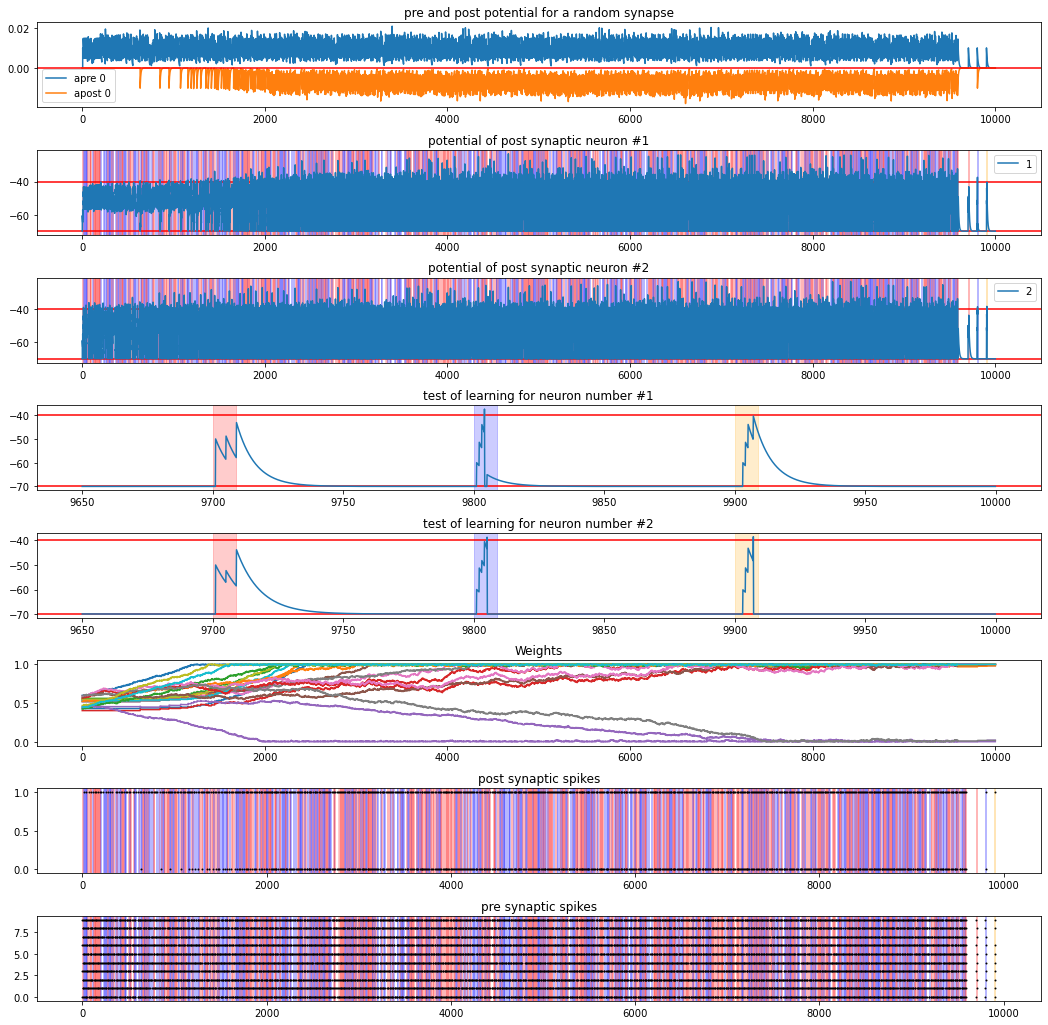

In [27]:
M_1 , M_2 , s1_1 , s1_2 , s2 , pattern_time , which_pattern , which_neuron , spike_time , u_mon_1 , u_mon_2 = simulate (coef = 5
    , duration = 10000*ms , Apre=0.01 , I_1 = 0 * Mohm , p_1 = 0 , I_2 = 0 * Mohm , p_2 = 0 , p_pattern = 0.8 , tau_pre =8*ms 
              , u_rest_post_1 = -70 * mV, tau_post_1 = 7 * ms , threshold_post_1 = -40 * mV , Resistance_post_1 = 1 * Mohm
              , u_rest_post_2 = -70 * mV, tau_post_2 = 9 * ms , threshold_post_2 = -40 * mV , Resistance_post_2 = 1 * Mohm)

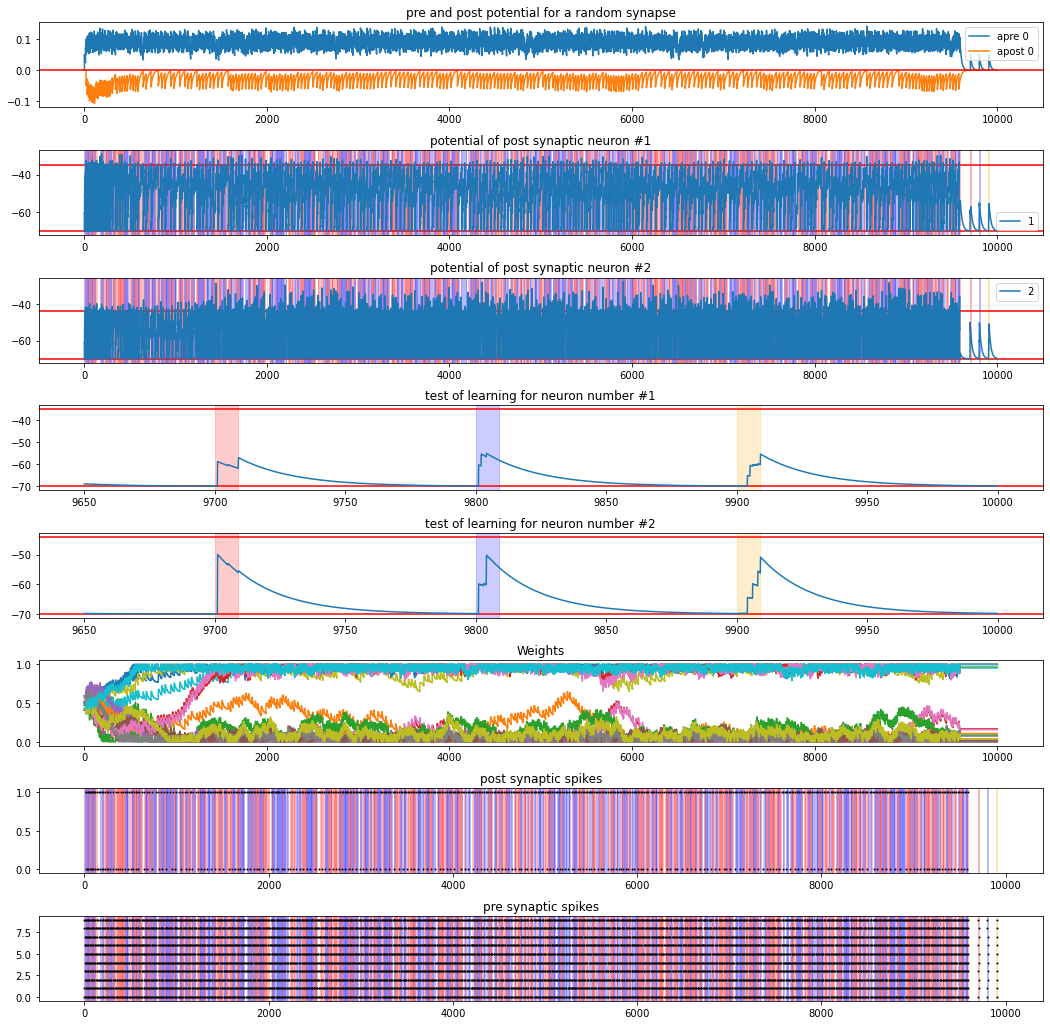

In [31]:
M_1 , M_2 , s1_1 , s1_2 , s2 , pattern_time , which_pattern , which_neuron , spike_time , u_mon_1 , u_mon_2 = simulate (coef = 5
    , duration = 10000*ms , Apre=0.05 , I_1 = 0 * Mohm , p_1 = 0 , I_2 = 0 * Mohm , p_2 = 0 , p_pattern = 0.8 , tau_pre =16*ms 
              , u_rest_post_1 = -70 * mV, tau_post_1 = 21 * ms , threshold_post_1 = -35 * mV , Resistance_post_1 = 1 * Mohm
              , u_rest_post_2 = -70 * mV, tau_post_2 = 20 * ms , threshold_post_2 = -44 * mV , Resistance_post_2 = 1 * Mohm)

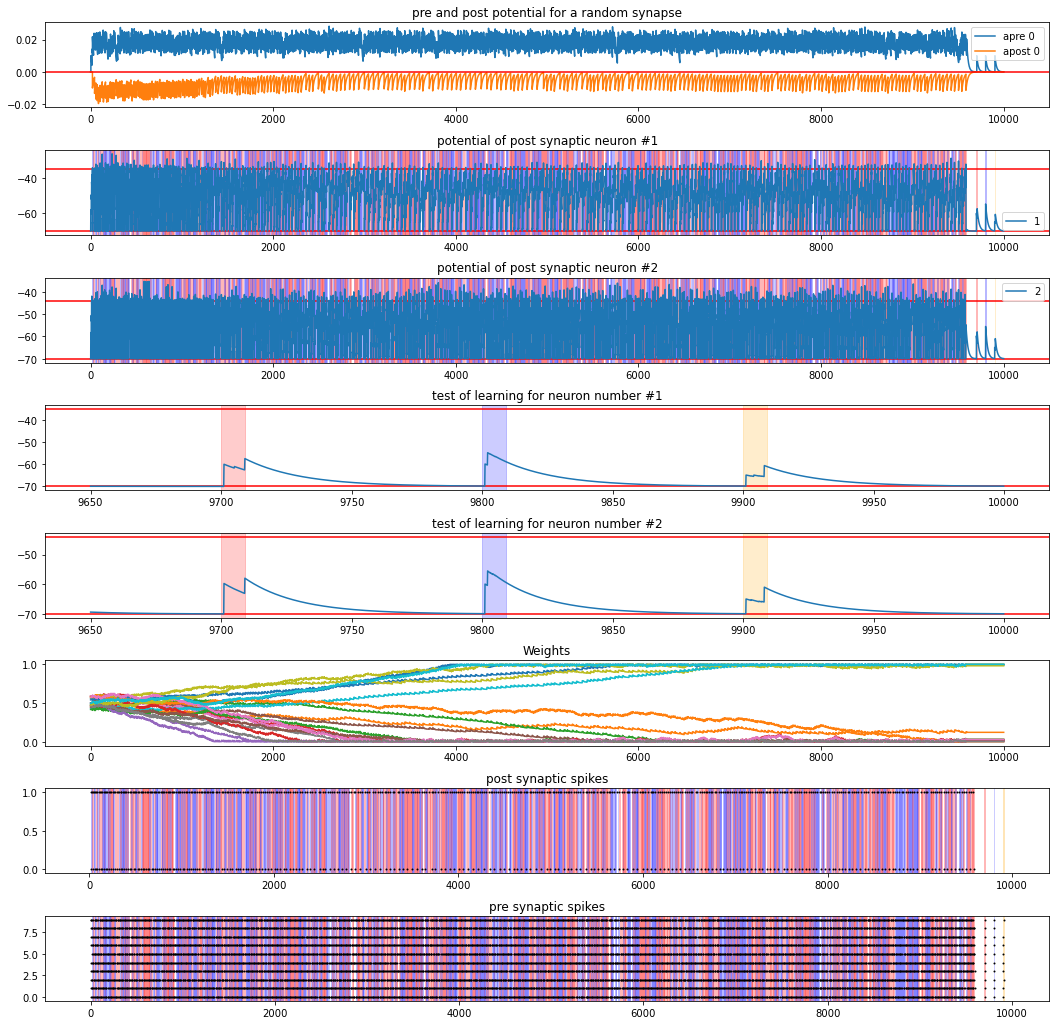

In [32]:
M_1 , M_2 , s1_1 , s1_2 , s2 , pattern_time , which_pattern , which_neuron , spike_time , u_mon_1 , u_mon_2 = simulate (coef = 5
    , duration = 10000*ms , Apre=0.01 , I_1 = 0 * Mohm , p_1 = 0 , I_2 = 0 * Mohm , p_2 = 0 , p_pattern = 0.8 , tau_pre =16*ms 
              , u_rest_post_1 = -70 * mV, tau_post_1 = 21 * ms , threshold_post_1 = -35 * mV , Resistance_post_1 = 1 * Mohm
              , u_rest_post_2 = -70 * mV, tau_post_2 = 20 * ms , threshold_post_2 = -44 * mV , Resistance_post_2 = 1 * Mohm)

In [ ]:
M_1 , M_2 , s1_1 , s1_2 , s2 , pattern_time , which_pattern , which_neuron , spike_time , u_mon_1 , u_mon_2 = simulate (coef = 4
    , duration = 10000*ms , Apre=0.01 , I_1 = 0 * Mohm , p_1 = 0 , I_2 = 0 * Mohm , p_2 = 0 , p_pattern = 0.8 , tau_pre =18*ms 
              , u_rest_post_1 = -65 * mV, tau_post_1 = 19 * ms , threshold_post_1 = -30 * mV , Resistance_post_1 = 1 * Mohm
              , u_rest_post_2 = -68 * mV, tau_post_2 = 23 * ms , threshold_post_2 = -32 * mV , Resistance_post_2 = 1 * Mohm)